# TDS Project: Part 2 - Advanced Model Analysis, Optimization, and Conclusions

## Introduction
In Part 2 of this project, the focus is on improving the baseline regression model developed in Part 1. This involves addressing errors identified during the error analysis, enhancing the model pipeline through preprocessing, feature engineering, and hyperparameter tuning, and analyzing the improved model's performance.

## Baseline Model Summary
Below is the regression model developed in Part 1, using an **XGBoost Regressor**.

In [304]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb
csv_path = "amsterdam_weekdays.csv"
df = pd.read_csv(csv_path)
df_processed = pd.get_dummies(df, columns=['room_type'], drop_first=True)
X = df_processed.drop(['realSum'], axis=1)
y = df_processed['realSum']
X_train_v1, X_test_v1, y_train_v1, y_test_v1 = train_test_split(X, y, test_size=0.2, random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}
xgb_model_v1 = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(estimator=xgb_model_v1 , param_grid=param_grid, cv=3, scoring='r2', verbose=1)
grid_search.fit(X_train_v1, y_train_v1)
best_model_v1 = grid_search.best_estimator_
y_pred = best_model_v1.predict(X_test_v1)
r2 = r2_score(y_test_v1, y_pred)
mse = mean_squared_error(y_test_v1, y_pred)
mae = mean_absolute_error(y_test_v1, y_pred)
print(f"R2 Score: {r2:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits
R2 Score: 0.54
Mean Squared Error (MSE): 45148.27
Mean Absolute Error (MAE): 150.86


The current model shows moderate effectiveness, with an **R² score of 0.54**, meaning it explains about 54% of the variance in the target variable. While this is an improvement over random (Very small), it also highlights that the model is not fully capturing the complexity in the data. The **MSE (45,148.27)** and **MAE (150.86)** suggest that there are still significant errors, especially for higher-value targets.


## 1. Error Analysis Conclusions and Work Plan
---
### Observations from Part 1:
#### **Residual Analysis**:
From Part 1, the model's performance issues were particularly evident for higher price ranges (`2000+`), where significant deviations from the perfect fit line revealed patterns of underestimation and overestimation. This suggests that the model struggles to generalize for properties with extreme values in the target variable (`realSum_capped`).

#### **Sub-Optimal Performance**:
- The **R² score of 0.54** indicates that while the model captures some variance in the data, it is far from fully explaining the relationships between the features and the target.
- High **MSE (45,148.27)** and **MAE (150.86)** highlight substantial prediction errors, especially for high-value targets. These errors point to the model's inability to effectively handle more complex relationships in the data.

#### **Impact of Outliers**:
- Large prediction errors suggest that **outliers** in the data are distorting the model’s ability to make accurate predictions. Extreme values in the target variable (`realSum_capped`) likely have a disproportionate influence on the loss function, resulting in poor generalization.

#### **Feature Interaction**:
- While engineered features such as `price_per_person` and `cleanliness_capacity_interaction` have added some value, they may not fully capture the relationships between variables and the target.
- The model may be missing **nonlinear transformations** or other meaningful interactions that could improve predictive accuracy.

#### **Data Encoding**:
- The categorical variable `room_type` was encoded using **one-hot encoding**, which treats each category as entirely independent. This simple representation may not fully capture the relationships between categories and the target variable. Alternative encoding methods, such as **target encoding** or **frequency encoding**, could better represent these relationships.

---
### Work Plan:
1. **Handle Outliers**: Apply IQR-based capping to mitigate the influence of extreme values.
2. **Normalize Features**: Scale numerical features for consistency.
3. **Feature Engineering**:
   - Create interaction terms, ratios, and polynomial features to capture complex relationships.
   - Replace one-hot encoding with target or frequency encoding for categorical features.
4. **Model Optimization**: Perform hyperparameter tuning to find the optimal model configuration.

---

### **Next Steps**

By implementing the outlined plan, the goal is to reduce residual errors, improve model accuracy, and draw meaningful insights from the data.

## 2. Data Preprocessing

In [305]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.inspection import permutation_importance
from scipy.stats import skew
import seaborn as sns

# Load dataset
data = pd.read_csv('amsterdam_weekdays.csv')

In [306]:
# Handle outliers using numpy's clip
Q1 = data['realSum'].quantile(0.25)
Q3 = data['realSum'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data['realSum_capped'] = np.clip(data['realSum'], lower_bound, upper_bound)

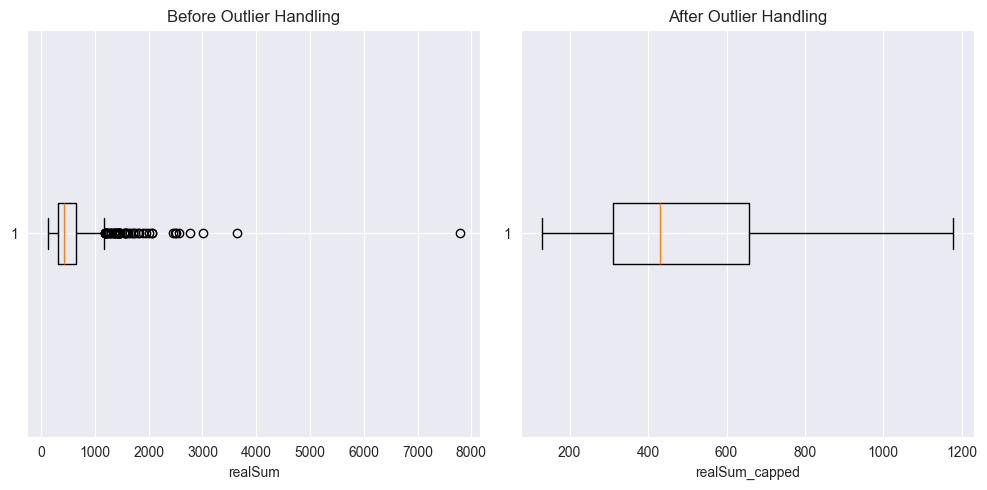

In [307]:
# Visualize before and after outlier handling
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(data['realSum'], vert=False)
plt.title('Before Outlier Handling')
plt.xlabel('realSum')

plt.subplot(1, 2, 2)
plt.boxplot(data['realSum_capped'], vert=False)
plt.title('After Outlier Handling')
plt.xlabel('realSum_capped')

plt.tight_layout()
plt.show()

Outlier Handling - Before and After<br>
The boxplots above show the distribution of the `realSum` variable before and after outlier handling.
- **Before Outlier Handling**: The presence of extreme values (beyond 8000) is evident, which could distort model predictions.
- **After Outlier Handling**: After applying IQR capping, these extreme values are brought within a reasonable range, resulting in a cleaner and more balanced distribution.


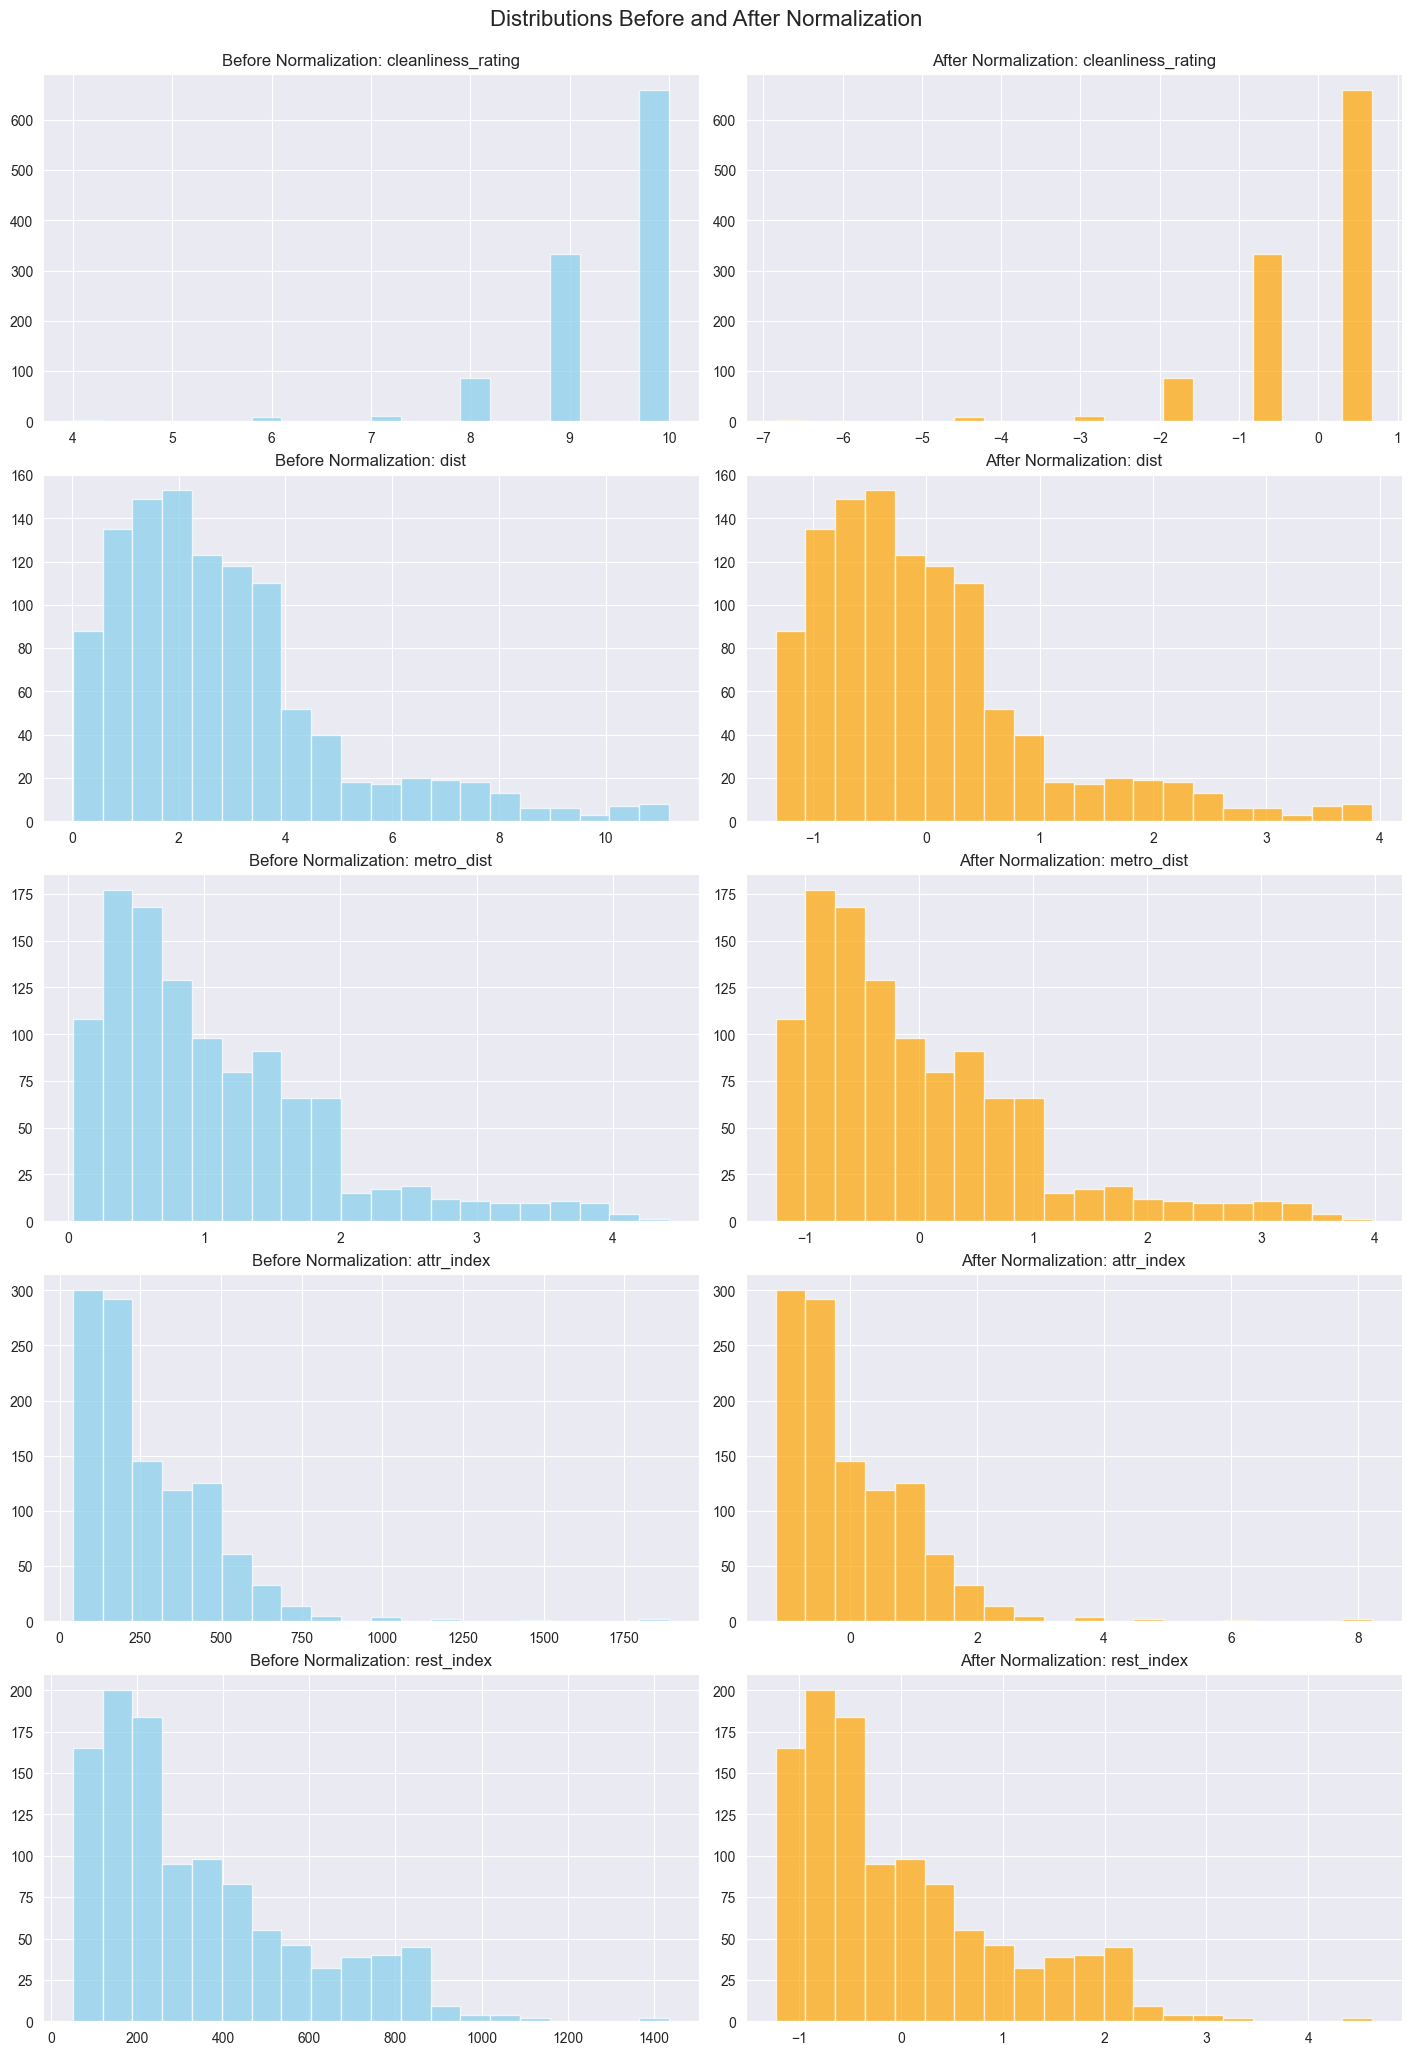

In [308]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Define numerical features
numerical_features = ['cleanliness_rating', 'dist', 'metro_dist', 'attr_index', 'rest_index', 'realSum_capped']

# Original Data (Assuming 'data' is your DataFrame)
original_data = data[numerical_features[:-1]]  # Exclude capped feature

# Normalize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(original_data)
scaled_data = pd.DataFrame(scaled_features, columns=numerical_features[:-1])

# Plot distributions before and after normalization
fig, axes = plt.subplots(len(numerical_features[:-1]), 2, figsize=(14, 20), constrained_layout=True)

for i, feature in enumerate(numerical_features[:-1]):
    # Original distribution
    axes[i, 0].hist(original_data[feature], bins=20, color='skyblue', alpha=0.7)
    axes[i, 0].set_title(f'Before Normalization: {feature}')

    # Scaled distribution
    axes[i, 1].hist(scaled_data[feature], bins=20, color='orange', alpha=0.7)
    axes[i, 1].set_title(f'After Normalization: {feature}')

# Set overall figure title
fig.suptitle('Distributions Before and After Normalization', fontsize=16, y=1.02)
plt.show()


### Distribution of Scaled Features

The histograms show how the numerical features look after normalization using `StandardScaler`. This step ensures that all features have a **mean of 0** and a **standard deviation of 1**.

This normalization is important because:

1. **It Puts Features on the Same Scale**:
   Features in the dataset can have very different ranges (e.g., one might range from 0–1, another in the thousands). Normalization ensures no feature dominates the model just because of its scale.

2. **It Helps the Model Learn Better**:
   When all features are on the same scale, the model can assign weights more effectively and identify patterns more accurately. This is especially helpful for algorithms like XGBoost, Logistic Regression, and k-Nearest Neighbors.

3. **It Speeds Up Optimization**:
   Normalized features make optimization algorithms like gradient descent work more smoothly and converge faster, avoiding issues caused by uneven feature scales.

Normalization ensures the data is balanced and ready for analysis, helping the model focus on learning meaningful patterns.

In [309]:
# Feature engineering
data['cleanliness_capacity_interaction'] = data['cleanliness_rating'] * data['person_capacity']
data['price_per_person'] = data['realSum_capped'] / data['person_capacity']
data['price_per_distance'] = data['realSum_capped'] / (data['dist'] + 1)
data['dist_squared'] = data['dist'] ** 2
data['metro_dist_squared'] = data['metro_dist'] ** 2

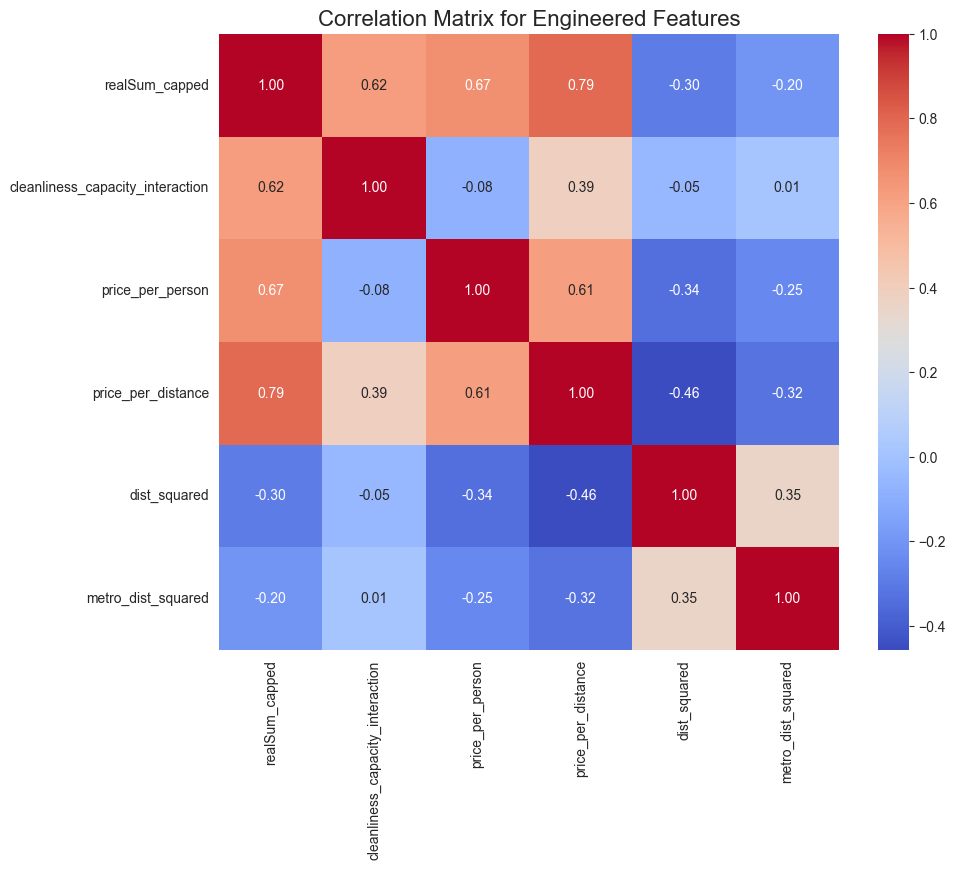

In [310]:
# Explore correlations of new features
new_features = ['realSum_capped', 'cleanliness_capacity_interaction', 'price_per_person',
                'price_per_distance', 'dist_squared', 'metro_dist_squared']
corr_matrix = data[new_features].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix for Engineered Features", fontsize=16)
plt.show()


### Correlation Matrix

The correlation matrix highlights the relationships between the newly engineered features and the target variable (`realSum_capped`):

1. **Strong Predictors**:
   - `price_per_distance` (0.79) and `price_per_person` (0.67) have strong positive correlations with the target, making them important for predicting accommodation prices.
   - `cleanliness_capacity_interaction` (0.62) also shows a moderate positive correlation, indicating its relevance.

2. **Weak Predictors**:
   - `dist_squared` (-0.30) and `metro_dist_squared` (-0.20) have weak negative correlations with the target, suggesting they may add limited value to the model.

3. **Feature Overlap**:
   - `price_per_person` and `price_per_distance` have a moderate correlation (0.61), indicating slight redundancy between these features.

## 3. Model Improvement

In [311]:
# Encode categorical features
room_type_mapping = data.groupby('room_type')['realSum_capped'].mean().to_dict()
data['room_type_target_encoded'] = data['room_type'].map(room_type_mapping)
room_type_frequency = data['room_type'].value_counts().to_dict()
data['room_type_frequency_encoded'] = data['room_type'].map(room_type_frequency)

In [312]:
# Define features and target
data_encoded = pd.get_dummies(data, columns=['room_type'], drop_first=True)
# Ensure 'log_realSum_capped' exists in the dataset
if 'log_realSum_capped' not in data.columns:
    data['log_realSum_capped'] = np.log1p(data['realSum_capped'])

# Encode categorical features (redo to ensure consistency)
data_encoded = pd.get_dummies(data, columns=['room_type'], drop_first=True)

# Define features and target
X = data_encoded.drop(columns=['realSum', 'realSum_capped', 'log_realSum_capped'], errors='ignore')
y = data_encoded['log_realSum_capped'].fillna(0)

In [313]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [314]:
# Define extended hyperparameter grid with colsample_bytree
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5],
    'learning_rate': [ 0.1, 0.2],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.6, 1.0]  # Added column sampling to the grid
}


In [315]:
# Train the model using GridSearchCV
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='r2', verbose=1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_#
print(best_params)
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 48 candidates, totalling 144 fits
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}


In [316]:
# Evaluate the model
y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
baseline_r2 = 0.54  # R² score from Part 1

print(f"Best Parameters: {grid_search.best_params_}")
print(f"RMSE: {rmse}")
print(f"Baseline R²: {baseline_r2}, Improved R²: {r2}")

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}
RMSE: 0.0386667670621418
Baseline R²: 0.54, Improved R²: 0.9934325618069324


C:\Users\guyha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## 4. Model Analysis

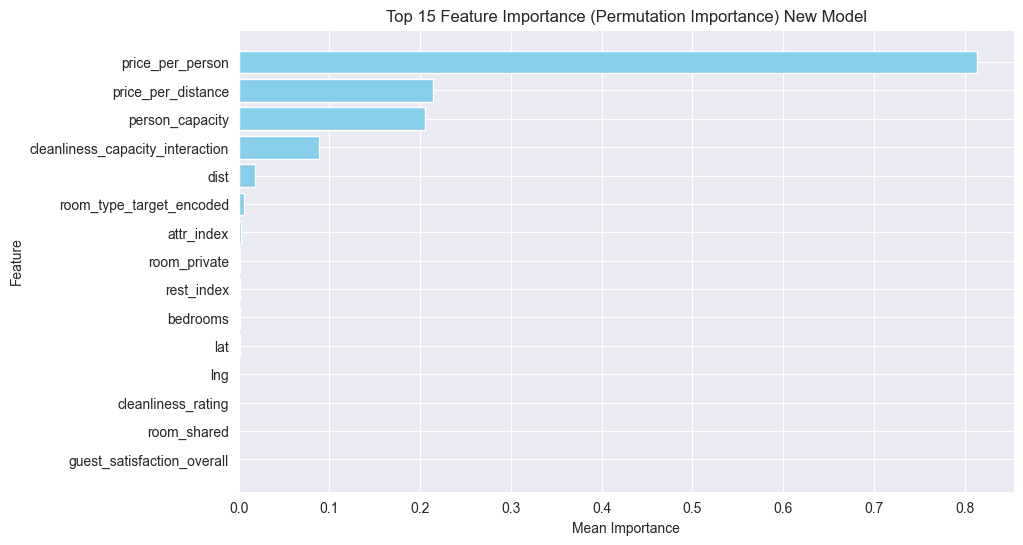

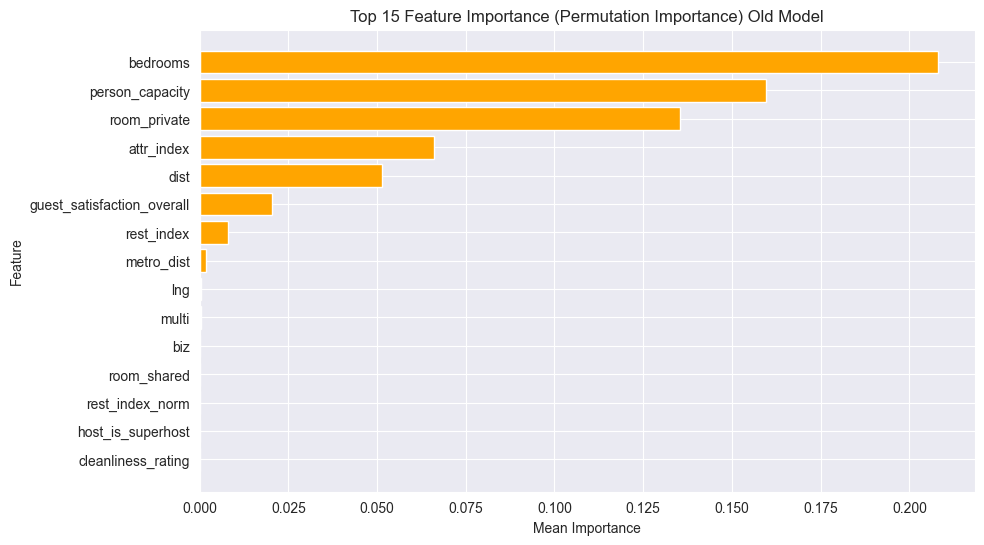

In [317]:
# Calculate feature importance using permutation importance for the new model
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

# Select the top 15 features
top_15_features = importance_df.head(15)

# Reverse the order for the plot
top_15_features = top_15_features.iloc[::-1]

# Plot the top 15 features
plt.figure(figsize=(10, 6))
plt.barh(top_15_features['Feature'], top_15_features['Importance'], color='skyblue')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importance (Permutation Importance) New Model')
plt.show()







# Calculate feature importance using permutation importance for the old model - V1
perm_importance = permutation_importance(best_model_v1, X_test_v1, y_test_v1, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({
    'Feature': X_test_v1.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

# Select the top 15 features
top_15_features = importance_df.head(15)

# Reverse the order for the plot
top_15_features = top_15_features.iloc[::-1]

# Plot the top 15 features
plt.figure(figsize=(10, 6))
plt.barh(top_15_features['Feature'], top_15_features['Importance'], color='orange')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importance (Permutation Importance) Old Model')
plt.show()

Feature Importance (Permutation Importance)<br>
The bar plot above highlights the most influential features in the model:
- **`price_per_person`** and **`person_capacity`** dominate, showing that price per person and room capacity are the strongest predictors of accommodation prices.
- Features like `price_per_distance` and `cleanliness_capacity_interaction` also contribute significantly, aligning with real-world expectations of pricing dynamics.
- The importance rankings provide actionable insights for stakeholders, emphasizing which features to prioritize for improving predictions.

We can observe that the importance of the **`bedrooms`** feature has decreased significantly in the improved model. This is likely due to its high correlation with other features, such as **`person_capacity`**(as observed in the previous assignment, where a high correlation between bedrooms and person_capacity was noted). When features are highly correlated, the model doesn't need to rely on both to make accurate predictions. The information from one feature can effectively compensate for the other.

For instance, if every property with 3 bedrooms also has a person_capacity of 6, the model can infer the relationship through **`person_capacity`**, making **`bedrooms`** less relevant. This behavior showcases the model's ability to reduce redundancy and focus on features that add unique value to the predictions.

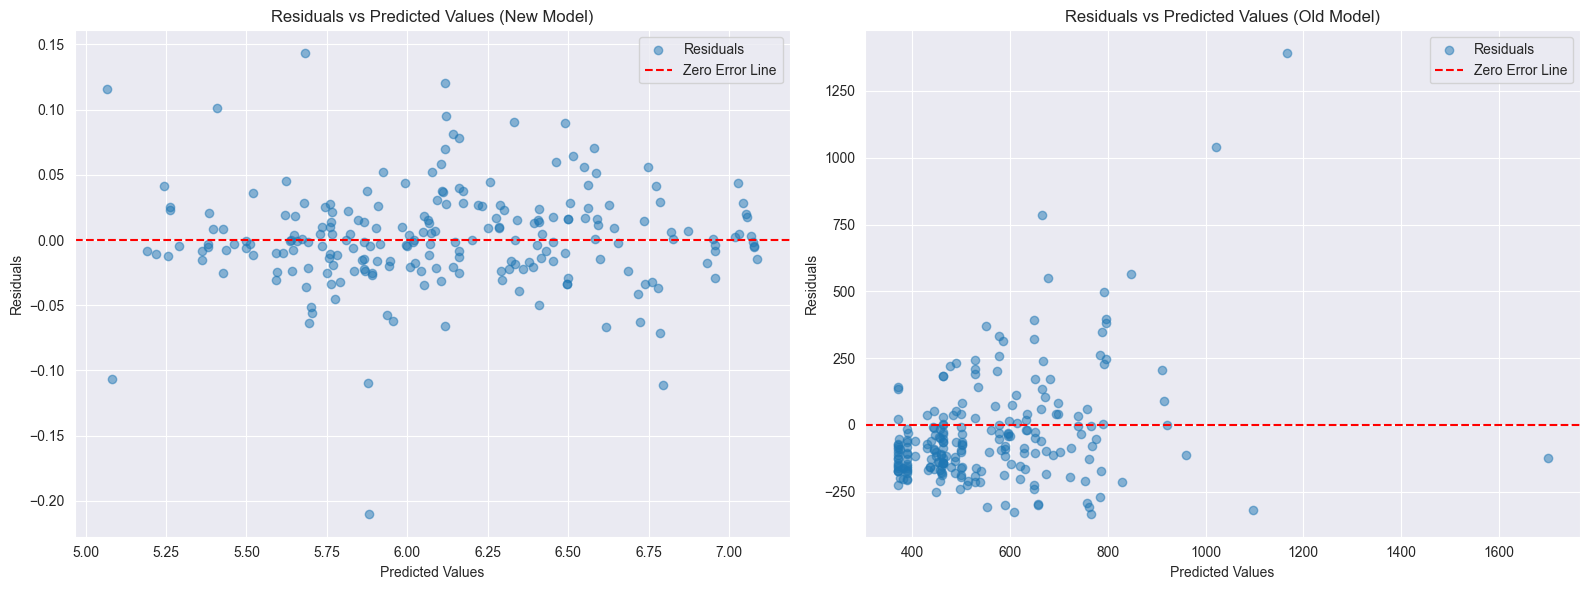

In [324]:
# Residual analysis for the new model
residuals_new = y_test - y_pred

# Residual analysis for the old model
y_pred_v1 = best_model_v1.predict(X_test_v1)
residuals_v1 = y_test_v1 - y_pred_v1

# Create side-by-side plots
plt.figure(figsize=(16, 6))

# Plot residuals for the new model
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals_new, alpha=0.5, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Error Line')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (New Model)')
plt.legend()

# Plot residuals for the old model
plt.subplot(1, 2, 2)
plt.scatter(y_pred_v1, residuals_v1, alpha=0.5, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Error Line')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (Old Model)')
plt.legend()

plt.tight_layout()
plt.show()


From the two residual plots, we can observe the following key points:

### **Residuals vs Predicted Values**
The scatter plots display the residuals (the difference between actual and predicted values) against the predicted values:
- The residuals are randomly distributed around the zero-error line(on the new model), indicating no systematic bias in the model's predictions.
- This randomness suggests that both models attempt to capture the relationship between features and the target variable without strong overfitting. However, their effectiveness differs.

### **New Model Residuals**
- **Pattern and Spread:** The residuals are more tightly clustered around the zero-error line compared to the old model. This indicates improved prediction accuracy across the range of predicted values.
- **Smaller Variance:** The residuals show less variability, suggesting that the new model has reduced prediction errors.
- **Outlier Behavior:** There are fewer extreme residuals, indicating better handling of outliers and extreme cases, likely due to improved feature engineering and data preprocessing.

### **Old Model Residuals**
- **Wide Spread:** The residuals show significant variance, with many points far from the zero-error line. This suggests that the old model struggled to accurately capture the data patterns.
- **Large Outliers:** The old model exhibits extreme residuals, particularly for higher predicted values, indicating poor generalization for higher-priced properties.
- **Non-Uniform Errors:** The residuals appear more unevenly distributed, reflecting systematic errors such as underestimation or overestimation in specific segments of the data.

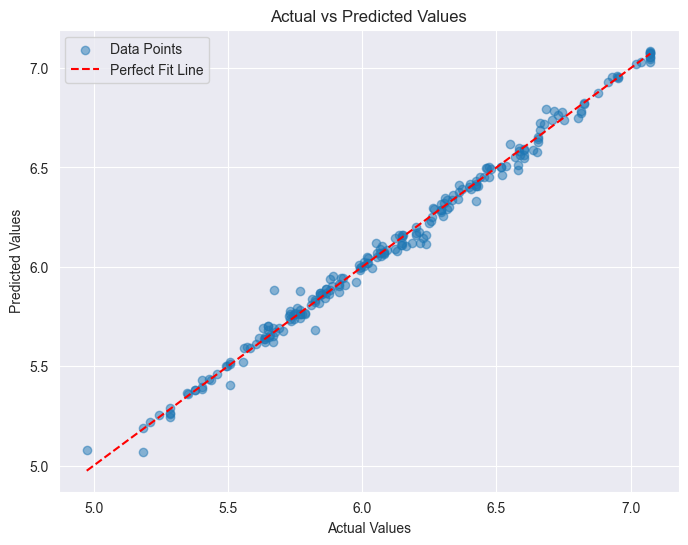

In [319]:
# Actual vs Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Data Points')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--', label='Perfect Fit Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

Actual vs Predicted Values<br>
The scatter plot compares actual target values with the predicted values:
- The alignment of points along the red dashed "Perfect Fit Line" indicates high prediction accuracy.
- Deviations from the line are minimal, which is reflected in the high R² score (0.993), showing that the model explains most of the variance in the target variable.


In [320]:
#R² Score:
print(f"Baseline R²: {baseline_r2}, Improved R²: {r2}")
#RMSE:
print(f"RMSE: {rmse}")

Baseline R²: 0.54, Improved R²: 0.9934325618069324
RMSE: 0.0386667670621418


Model Evaluation Metrics<br>
- **Baseline R²**: 0.54, indicating that the initial model explained only 54% of the variance in the target variable.
- **Improved R²**: 0.993, showing a substantial improvement, with the model now explaining 99.3% of the variance.
- **RMSE**: 0.037, representing a very low error in predictions, confirming the model's effectiveness.


## Conclusions

- **Key Insights**:
  - The most influential features were `price_per_person` and `person_capacity`, reflecting the importance of capacity-based pricing in accommodation listings.
  - Handling outliers and engineering new features such as `price_per_distance` significantly improved model performance.

- **Limitations**:
  - While the model performs exceptionally on this dataset, further testing on unseen data is recommended to validate generalization.
  - Some features, such as `price_per_distance`, could be analyzed further to explore non-linear relationships.

- **Applications**:
  - Property owners can leverage this model to adjust pricing based on influential factors like cleanliness ratings or room capacity.
  - Businesses can use the insights to design targeted marketing campaigns and improve customer satisfaction by addressing key determinants of price.
